# ML Monitoring - Model analysis regression

## Overview

In this notebook we focus on model analysis. Specifically feature sliced model analysis and model performance over time and good vs bad performance

## Dataset:

* Contains warehouse demand data from 2017-01-01 to 2020-11-15
* Working with preprocessed data
* No data leakage as missing values were filled without requirement of any transformation

## Assumptions

* Initial model deployment on march 2019
* True labels/ actual demand available over the weekend
* Model monitored on weekly basis

## Libraries

In [322]:
import pandas as pd
import numpy as np
from datetime import date,datetime,timedelta
import time
from sklearn.model_selection import train_test_split
from rdt import HyperTransformer
import xgboost as xgb
import optuna
import traceback
import shap
import pickle
import logging
from importlib import reload
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from evidently import ColumnMapping
from evidently.analyzers.stattests import StatTest
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab, NumTargetDriftTab, RegressionPerformanceTab
from evidently.options import DataDriftOptions
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, NumTargetDriftProfileSection
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import os
import json
import mlflow
from functools import wraps
from mlflow.tracking import MlflowClient
import plotly.io as pio
# remove static rendering to allow interactive mode
pio.renderers.default = "svg"
%matplotlib inline

In [323]:
# set up logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [324]:
# mlflow runner
def mlflow_runner(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # log into MLflow
        client = MlflowClient()
        experiment_name = kwargs['experiment_name']
        run_name = kwargs['run_name']
        try:
            mlflow.set_experiment(experiment_name)
        except Exception:
            logging.error('Experiment does not exists')
            logging.error('Stack trace:{}'.format(traceback.format_exc()))
            experiment_id = mlflow.create_experiment(experiment_name)
            mlflow.set_experiment(experiment_name)
        finally:
            with mlflow.start_run(run_name=run_name) as run:
                rv = func(*args, **kwargs)
            return rv

    return wrapper

## Data

### Load data

In [325]:
df = pd.read_csv('cpp_demand_forecasting_clean_data_v2.csv', index_col=0)

In [326]:
logging.info(f'dataset shape : {df.shape}')

06:03:54 INFO:dataset shape : (13315, 33)


In [327]:
# set random state
rng = np.random.RandomState(0)

In [328]:
df.head(2)

,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,...,statewise_land_area_per_sqmile,statewise_population_per_sqmile,statewise_geographic_region,geographic_region_division,statewise_median_age,statewise_median_household_income,total_count,yearly_count,monthly_count,weekly_count
ID,,,,,,,,,,,,,,,,,,,,,
0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,1,Yes,No,5.5,...,4842,744.722016,new_england,north_east,41.2,78833,0,0,0,0
0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.183060,Type_A,2017,1,Yes,No,6.1,...,103642,56.078318,mountain,west,37.3,41053,0,0,0,0


In [329]:
df.date = pd.to_datetime(df.date)

In [330]:
# Split the dataset
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     shuffle=False,
                                     random_state=rng)
eval_df, serve_df = train_test_split(test_df,
                                     test_size=0.5,
                                     shuffle=False,
                                     random_state=rng)

In [331]:
logging.info(f'train_df shape : {train_df.shape}')
logging.info(f'eval_df shape : {eval_df.shape}')
logging.info(f'serve_df shape : {serve_df.shape}')

06:03:59 INFO:train_df shape : (10652, 33)
06:03:59 INFO:eval_df shape : (1331, 33)
06:03:59 INFO:serve_df shape : (1332, 33)


### Data preprocessing

In [332]:
def split_features_target(df):
    target =  'daily_dispatch_count'
    drop_feats = ['weekly_dispatch_count']
    y = df[target]
    X = df.drop(columns = drop_feats+[target])
    return X,y

In [333]:
X,y = split_features_target(train_df)
X_eval,y_eval = split_features_target(eval_df)
X_serve,y_serve = split_features_target(serve_df)

### Data transformation

In [334]:
ht = HyperTransformer()

In [335]:
ht.detect_initial_config(data=X)

Detecting a new config from the data ... SUCCESS
Setting the new config ... SUCCESS
Config:
{
    "sdtypes": {
        "date": "datetime",
        "warehouse_ID": "categorical",
        "Latitude": "numerical",
        "Longitude": "numerical",
        "Product_Type": "categorical",
        "year": "numerical",
        "month": "numerical",
        "is_weekend": "categorical",
        "is_warehouse_closed": "categorical",
        "week": "numerical",
        "state": "categorical",
        "county": "categorical",
        "state_cases": "numerical",
        "state_deaths": "numerical",
        "county_cases": "numerical",
        "county_deaths": "numerical",
        "day_of_week": "numerical",
        "days_since_warehouse_started": "numerical",
        "state_abbr": "categorical",
        "is_holiday": "numerical",
        "statewise_population": "numerical",
        "statewise_land_area_per_sqmile": "numerical",
        "statewise_population_per_sqmile": "numerical",
        "statew

In [336]:
ht.fit(X)
X_transformed = ht.transform(X)
X_eval_transformed = ht.transform(X_eval)
X_serve_transformed = ht.transform(X_serve)

## Modelling

In [337]:
@mlflow_runner
def fit_model(X,y, X_test,y_test, params=None,mlflow_log = False, experiment_name=None, run_name = None):
    if params:
        reg = xgb.XGBRegressor(**params)
    else:
        reg = xgb.XGBRegressor()
    reg.fit(X,y,eval_set=[(X_test,y_test)],early_stopping_rounds=10,verbose=False)
    if mlflow_log:
        mlflow.log_dict(reg.get_params(),'xgboost_regressor_params')
        
    return reg

In [338]:
reg = fit_model(X_transformed,y, X_eval_transformed,y_eval, mlflow_log=True,experiment_name='ml_monitoring_model_analysis',run_name=str(int(time.mktime(datetime.now().timetuple()))))

d:\anaconda\envs\anaconda_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



## Model analysis

#### Metric selection

In Demand forecasting , models are exepcted to handle special events. 

* MAE doesn't penalize model for underperformance of during special events. 
* MAPE is not a good metric for demand forecasting. MAPE divides each error individually by the demand, so it is skewed: high errors during low-demand periods will significantly impact MAPE.
* MSE is not scaled to the original error (as the error is squared), resulting in a KPI that we cannot relate to the original demand scale.
* RMSE is sensitive to outliers and does penalize model for underperformance on special events.
<div><b>We will convert RMSE to RMSE% to scale RMSE to average demand. Otherwise we will get skewed results during very low demand period. This will also make the results more interpretable</b></div>

In [339]:
def rewrite_name(df_type, error_type):
    return f"{df_type}{'_'}{error_type}"

def get_scores(y_actual, y_predicted,df_type='train'):
    #y_predicted = np.expm1(y_predicted)
    #y_actual = np.expm1(y_actual)
    rmse = mean_squared_error(y_actual, y_predicted, squared=False)
    rmse_scaled_to_demand = rmse / (np.sum(y_actual / y_actual.shape[0])) * 100
    mse = mean_squared_error(y_actual, y_predicted, squared=True)
    #mae = mean_absolute_error(y_actual, y_predicted)
    mape = mean_absolute_percentage_error(y_actual, y_predicted)
    scores = {rewrite_name(df_type, 'rmse'):rmse, rewrite_name(df_type, 'rmse_scaled_to_average_demand'):rmse_scaled_to_demand}
    return scores

def dataset_results(X,y, model, df_type):

    y_pred = model.predict(X)
    
    return get_scores(y,y_pred,df_type)
    

### Feature sliced performance analysis

In [340]:
def get_feature_sliced_model_performance_per_dataset(features, model, X,y,  df_type):
    if features:
        return X.groupby(features).apply(lambda x:dataset_results(x.reset_index().set_index('ID'),y.loc[x.index], model, df_type))
    else:
        return pd.DataFrame(dataset_results(X.reset_index().set_index('ID'),y, model, df_type),index=[0])

In [341]:
def feature_sliced_performance_analysis_per_dataset(features, model, X,y, time_scale_str):
    
    train_results = get_feature_sliced_model_performance_per_dataset(features, model, X,y, time_scale_str)
    results = None
    if features:
        combined_results = train_results.to_frame(name = 'train').reset_index()
        results = pd.json_normalize(combined_results['train'])
        results[features] = combined_results[features]
     
        results = results[ features + [ col for col in results.columns if col not in features ] ]
        results[features] = ht.reverse_transform_subset(results[features])
    else:
        results = train_results
    return results

In [342]:
def feature_sliced_performance_analysis_train_test_serve(features, model, X,y, X_test,y_test, X_serve, y_serve ):
    
    train_results = get_feature_sliced_model_performance_per_dataset(features, model, X,y, 'train')
    test_results = get_feature_sliced_model_performance_per_dataset(features,model, X_test,y_test, 'eval')
    serve_results = get_feature_sliced_model_performance_per_dataset(features,model, X_serve,y_serve, 'serve')
    results = None
    if features:
        combined_results = train_results.to_frame(name = 'train').join(test_results.to_frame(name='eval')).join(serve_results.to_frame(name='serve')).reset_index()
        results = pd.json_normalize(combined_results['train']).join(pd.json_normalize(combined_results['eval'])).join(pd.json_normalize(combined_results['serve']))
        results[features] = combined_results[features]
     
        results = results[ features + [ col for col in results.columns if col not in features ] ]
        results[features] = ht.reverse_transform_subset(results[features])
    else:
        results = train_results.join(test_results).join(serve_results)
    results['overfit_train_eval'] = results['eval_rmse'] - results['train_rmse']
    results['overfit_train_serve'] = results['serve_rmse'] - results['train_rmse']
    results['overfit_eval_serve'] = results['serve_rmse'] - results['eval_rmse']
    return results

#### Overall results

In [343]:
model_results = feature_sliced_performance_analysis_train_test_serve([], reg, X_transformed,y, X_eval_transformed, y_eval, X_serve_transformed, y_serve)
model_results

,train_rmse,train_rmse_scaled_to_average_demand,eval_rmse,eval_rmse_scaled_to_average_demand,serve_rmse,serve_rmse_scaled_to_average_demand,overfit_train_eval,overfit_train_serve,overfit_eval_serve
0,0.932556,15.271851,1.893495,42.263246,2.065079,55.714593,0.960939,1.132523,0.171584


In [344]:
model_results = feature_sliced_performance_analysis_train_test_serve(['warehouse_ID.value','Product_Type.value'], reg, X_transformed,y, X_eval_transformed, y_eval, X_serve_transformed, y_serve)
model_results.insert(1,'state.value', model_results['warehouse_ID.value'].map(df[['warehouse_ID','state']].drop_duplicates().set_index('warehouse_ID').to_dict()['state']))

#### Top 5 best performance for a given warehouse and product type

In [345]:
model_results.sort_values(by='serve_rmse').head(5)

,warehouse_ID.value,state.value,Product_Type.value,train_rmse,train_rmse_scaled_to_average_demand,eval_rmse,eval_rmse_scaled_to_average_demand,serve_rmse,serve_rmse_scaled_to_average_demand,overfit_train_eval,overfit_train_serve,overfit_eval_serve
13,WH_0x3ef,illinois,Type_B,0.639319,28.207501,0.951817,71.015314,0.757947,52.712824,0.312498,0.118627,-0.193871
9,WH_0x3ed,florida,Type_B,0.502831,16.070494,0.921207,65.106382,0.849468,72.687577,0.418376,0.346637,-0.071738
11,WH_0x3ee,florida,Type_B,0.539882,17.452200,1.022442,69.759300,0.906493,73.140055,0.482561,0.366612,-0.115949
7,WH_0x3ec,alabama,Type_B,0.529527,13.783625,1.097985,44.926845,1.072267,53.814140,0.568458,0.542740,-0.025718
1,WH_0x3e9,connecticut,Type_B,0.500420,14.072102,0.949551,52.356173,1.185981,70.133030,0.449131,0.685561,0.236430


#### Top 5 worst performance for a given warehouse and product type

In [346]:
model_results.sort_values(by='serve_rmse',ascending=False).head(5)

,warehouse_ID.value,state.value,Product_Type.value,train_rmse,train_rmse_scaled_to_average_demand,eval_rmse,eval_rmse_scaled_to_average_demand,serve_rmse,serve_rmse_scaled_to_average_demand,overfit_train_eval,overfit_train_serve,overfit_eval_serve
4,WH_0x3eb,arizona,Type_A,1.098947,11.958843,2.385502,28.851592,3.309782,52.861831,1.286555,2.210835,0.924280
6,WH_0x3ec,alabama,Type_A,1.169789,13.361338,2.335616,31.954947,3.033126,54.322219,1.165828,1.863337,0.697510
14,WH_0x3f1,idaho,Type_A,1.605649,21.680834,2.558170,35.405364,2.819205,47.611950,0.952521,1.213556,0.261035
8,WH_0x3ed,florida,Type_A,1.037008,15.941043,2.687187,59.126930,2.783675,69.127581,1.650178,1.746667,0.096488
10,WH_0x3ee,florida,Type_A,1.177379,18.308723,2.403213,49.105000,2.746987,72.289132,1.225835,1.569608,0.343774


#### least overfitted warehouse Id and product type

In [347]:
model_results.sort_values(by='overfit_train_serve').head(5)

,warehouse_ID.value,state.value,Product_Type.value,train_rmse,train_rmse_scaled_to_average_demand,eval_rmse,eval_rmse_scaled_to_average_demand,serve_rmse,serve_rmse_scaled_to_average_demand,overfit_train_eval,overfit_train_serve,overfit_eval_serve
13,WH_0x3ef,illinois,Type_B,0.639319,28.207501,0.951817,71.015314,0.757947,52.712824,0.312498,0.118627,-0.193871
19,WH_0x3f2,alaska,Type_B,1.018515,41.443908,1.225502,44.860291,1.276562,67.082067,0.206986,0.258046,0.051060
18,WH_0x3f2,alaska,Type_A,2.125209,25.465468,2.336458,29.486281,2.412080,34.221257,0.211249,0.286871,0.075622
17,WH_0x3f0,illinois,Type_B,0.944769,29.859366,1.284718,46.079300,1.243993,52.664235,0.339949,0.299224,-0.040725
9,WH_0x3ed,florida,Type_B,0.502831,16.070494,0.921207,65.106382,0.849468,72.687577,0.418376,0.346637,-0.071738


#### Most overfitted warehouse Id and product type

In [348]:
model_results.sort_values(by='overfit_train_serve',ascending=False).head(5)

,warehouse_ID.value,state.value,Product_Type.value,train_rmse,train_rmse_scaled_to_average_demand,eval_rmse,eval_rmse_scaled_to_average_demand,serve_rmse,serve_rmse_scaled_to_average_demand,overfit_train_eval,overfit_train_serve,overfit_eval_serve
4,WH_0x3eb,arizona,Type_A,1.098947,11.958843,2.385502,28.851592,3.309782,52.861831,1.286555,2.210835,0.924280
6,WH_0x3ec,alabama,Type_A,1.169789,13.361338,2.335616,31.954947,3.033126,54.322219,1.165828,1.863337,0.697510
8,WH_0x3ed,florida,Type_A,1.037008,15.941043,2.687187,59.126930,2.783675,69.127581,1.650178,1.746667,0.096488
10,WH_0x3ee,florida,Type_A,1.177379,18.308723,2.403213,49.105000,2.746987,72.289132,1.225835,1.569608,0.343774
0,WH_0x3e9,connecticut,Type_A,0.969849,13.070520,2.334528,41.687995,2.250917,43.524233,1.364679,1.281069,-0.083610


### Performance over time

#### Weekly performance

In [349]:
def simulate_Weekly_experiment(df, model, features):
    weekly_feature_sliced_performance = pd.DataFrame()
    #print(df.shape)
    while df.shape[0] > 0:
        # Get weekly data
        row = df.iloc[0]
        dt = row['date']
        start = dt - timedelta(days=row['date'].weekday())
        end = start + timedelta(days=6)
        sub_df = df.set_index('date')[start:end]
        sub_df = sub_df.reset_index().set_index('ID')
        df = df[(df.date.dt.date > end.date())]
        #print(f'week begin {start.to_pydatetime()}')
        #print(f'week end {end.to_pydatetime()}')
        #print(df.shape)
        
        # Transform sub_df to X, y
        X_prod,y_prod = split_features_target(sub_df)
        X_prod_transformed = ht.transform(X_prod)
        
        # weekly_prediction
        #weekly_overall_performane = feature_sliced_performance_analysis_per_dataset([], reg, X_prod_transformed, y_prod)
        current_week_performance = feature_sliced_performance_analysis_per_dataset(features, model, X_prod_transformed, y_prod, 'weekly')
        current_week_performance['week_begin_date'] = start.to_pydatetime()
        current_week_performance['week_end_date'] = end.to_pydatetime()
        weekly_feature_sliced_performance = weekly_feature_sliced_performance.append(current_week_performance)
        feature_list = [feat.split('.')[0]  for feat in features]
        feature_list_join = '_'.join(str(x) for x in feature_list)
        features_name_combo = feature_list_join+'_combo'
        weekly_feature_sliced_performance[features_name_combo] = weekly_feature_sliced_performance[features].agg(' '.join, axis=1)
        
    return weekly_feature_sliced_performance

In [350]:
weekly_feature_sliced_performance = simulate_Weekly_experiment(serve_df.reset_index(), reg, ['warehouse_ID.value','Product_Type.value'])

#### Weekly performance for Top 3 best performance for a given warehouse and product type

In [351]:
def filter_weekly_performance(features, metric, n, best = True):

    top_n_performance = model_results.sort_values(by=metric,ascending=best).head(n)
    top_n_performance[features]
    feature_list = [feat.split('.')[0]  for feat in features]
    feature_list_join = '_'.join(str(x) for x in feature_list)
    features_name_combo = feature_list_join+'_combo'
    top_n_performance[features_name_combo] = top_n_performance[features].agg(' '.join, axis=1)
    return weekly_feature_sliced_performance[weekly_feature_sliced_performance[features_name_combo].isin(top_n_performance[features_name_combo])]

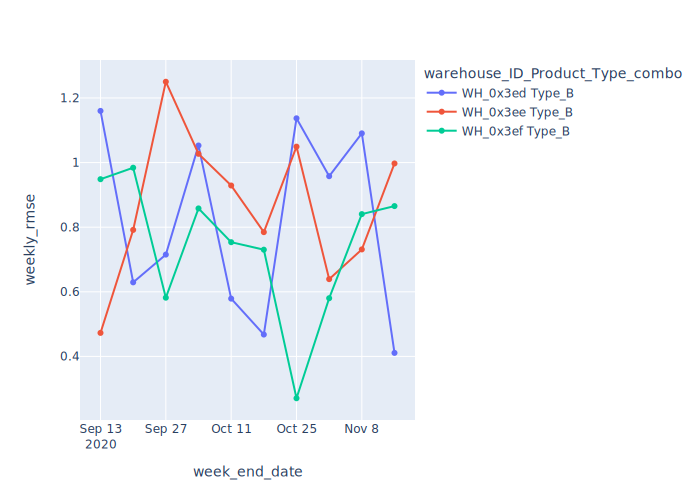

In [352]:
fig = px.line(filter_weekly_performance(['warehouse_ID.value','Product_Type.value'], 'serve_rmse', 3, best = True), x="week_end_date", y="weekly_rmse", color='warehouse_ID_Product_Type_combo', markers=True)
fig.show()

#### Weekly performance for Top 3 worst performance for a given warehouse and product type

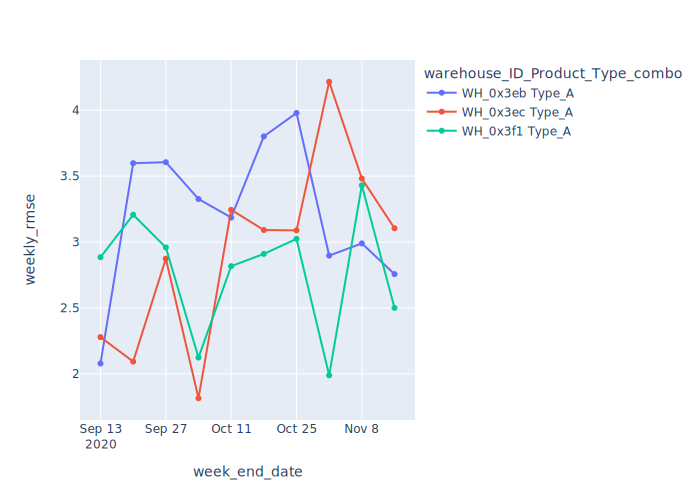

In [353]:
fig = px.line(filter_weekly_performance(['warehouse_ID.value','Product_Type.value'], 'serve_rmse', 3, best = False), x="week_end_date", y="weekly_rmse", color='warehouse_ID_Product_Type_combo', markers=True)
fig.show()

### Residual analysis

to continue